# Creates input for Gat2Vec using STRING

In this notebook we add the disease-gene association information, obtained from PheWAS Catalog, to the GuiltyTargets pipeline. The run is tested using STRING PPI network and AMP-AD MSBB gene expression data (Brodmann area 10).

## Imports and definitions

In [7]:
import warnings

import itertools
import os

import bio2bel_phewascatalog
from guilty_phewas.string_ppi_assembler import StringAssembler
from guilty_phewas.utils import generate_phewas_file
from guiltytargets.pipeline import rank_targets
from guiltytargets.ppi_network_annotation.parsers import parse_gene_list
import matplotlib.pyplot as plt
import pandas as pd
from ppi_network_annotation import AttributeNetwork, LabeledNetwork, Network, generate_ppi_network, \
    parse_dge

In [2]:
# Suppress warnings
warnings.simplefilter('ignore')

targets_file = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\data\ot_entrez.txt'
# file generated by the script src\r_scripts\DiffExpr.R
input_path = r'C:\Users\Mauricio\Thesis\DGE data\AMP-AD'
dge_path = r'C:\Users\Mauricio\Thesis\DGE data\AMP-AD\DifferentialExpression_BM10.csv'
data_dir = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks'
phewas_path = r'C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\phewas.txt'
string_path = os.path.join(data_dir, 'string.edgelist')

graph_paths = [string_path]
lfc_cutoffs = [0.5, 1.0, 1.5]
confidence_cutoffs = [0.0, 0.63]

# for differential expression
max_padj = 0.05
base_mean_name = 'baseMean' or None  # it was None
log_fold_change_name = 'log2FoldChange'
adjusted_p_value_name = 'padj'
entrez_id_name = 'symbol'
split_char = '///'
diff_type = 'all'

## Filter the columns from the STRING file

In [3]:
assembler = StringAssembler()
assembler.create_adj_file()


## Gene disease associations

In [4]:
generate_phewas_file(phewas_path)    

PheWAS Catalog - generating Dict: 100%|██████████████████████████████████████| 215107/215107 [00:21<00:00, 9795.00it/s]


In [3]:
gene_list = parse_dge(
    dge_path=dge_path,
    entrez_id_header=entrez_id_name, 
    log2_fold_change_header=log_fold_change_name,
    adj_p_header=adjusted_p_value_name,
    entrez_delimiter=split_char,
    base_mean_header=base_mean_name,
)

Initializing gat2vec
loading structural graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_graph.adjlist
Number of nodes: 19344
loading attribute graph
C:\Users\Mauricio\Thesis\DGE data\AMP-AD\AMP-AD_na.adjlist
Number of nodes: 19344
Random Walks on Structural Graph
Random Walks on Attribute Graph
Learning Representation
Learned Representation Saved
Training Finished
0.988595492043768
C:\Users\Mauricio\Thesis\git\guiltyreloaded\notebooks\string.edgelist 0.5 0.0
    accuracy   f1micro   f1macro       auc
TR                                        
0   0.998449  0.998449  0.528183  0.950253
1   0.998397  0.998397  0.524599  0.948173
2   0.998449  0.998449  0.528183  0.933146
3   0.998449  0.998449  0.553183  0.945284
4   0.998449  0.998449  0.528183  0.947880
5   0.998449  0.998449  0.528183  0.949028
6   0.998501  0.998501  0.556768  0.947588
7   0.998294  0.998294  0.528145  0.939056
8   0.998397  0.998397  0.528170  0.942657
9   0.998501  0.998501  0.553196  0.953998
Initializing ga

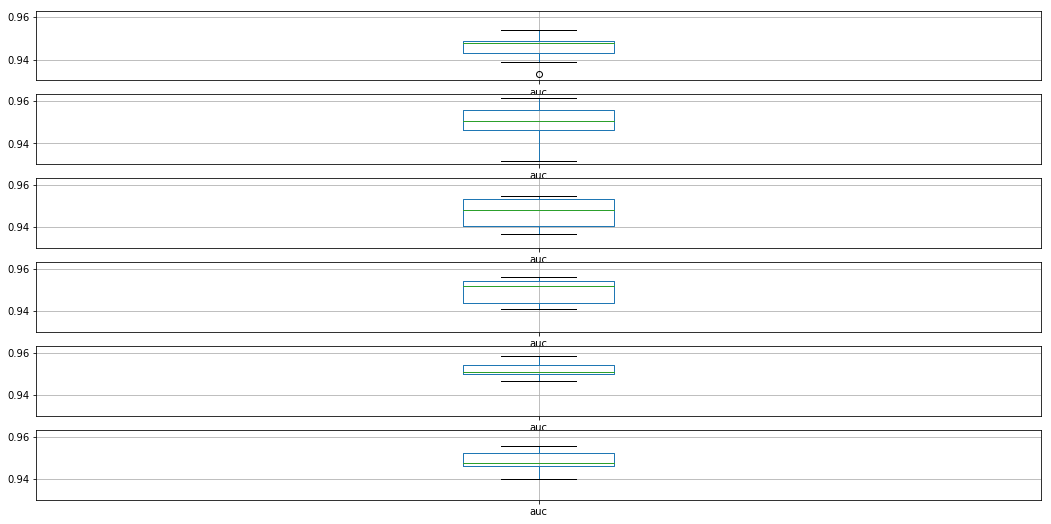

In [8]:
%%time

dim = len(graph_paths)* len(lfc_cutoffs)* len(confidence_cutoffs)
fig, axs = plt.subplots(ncols=dim, sharey=True)

fig.set_size_inches(18, 9)

optmization = pd.DataFrame()

axs_ind = 0
for ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence in itertools.product(
    graph_paths, lfc_cutoffs, confidence_cutoffs
):
    max_log2_fold_change, min_log2_fold_change = lfc_cutoff, lfc_cutoff * -1
    
    network = generate_ppi_network(
        ppi_graph_path=ppi_graph_path, #
        dge_list=gene_list, #
        max_adj_p=max_padj, #
        max_log2_fold_change=max_log2_fold_change,# 
        min_log2_fold_change=min_log2_fold_change,#
        ppi_edge_min_confidence=ppi_edge_min_confidence,# 
        disease_associations_path=phewas_path, #
    )

    targets = parse_gene_list(targets_file, network.graph, anno_type="symbol")

    auc_df, probs_df = rank_targets(
        directory=input_path,
        targets=targets,
        network=network,
    )
    
    print(ppi_graph_path, lfc_cutoff, ppi_edge_min_confidence)
    print(auc_df)
    auc_df.boxplot(column=['auc'], ax=axs[axs_ind])
    axs_ind += 1
    